In [1]:
import os
import numpy as np 
from numpy import arctan2
import cv2 
import matplotlib.pylab as plt

In [2]:
img = cv2.imread('test.png')

In [3]:
def plot_img(im, h=8, **kwargs):
  # Copied from internet to make life a bit easier
  y = im.shape[0]
  x = im.shape[1]
  w = (y/x) * h
  plt.figure(figsize=(w,h))
  plt.imshow(im, interpolation="none", **kwargs)
  plt.axis('off')

In [4]:
def double_size(img):
    x,y,z = img.shape
    temp = np.zeros((x*2,y*2,z))
    for z in range(z):
        for y in range(y):
            for x in range(x):
                temp[x*2:x*4, y*2:y*4,z] = img[x,y,z]
    return temp

In [169]:

def magn_orient(img):
    gx = np.array([])
    gy = np.array([])
    gradient = np.array([])
    orientation = np.array([])
    
    for z in range (img.shape[2]):
        for y in range(img.shape[1]):
            for x in range(img.shape[0]):
                if x == 0:
                    gx = np.append(gx, 0* img[x,y,z] + 1* img[x+1,y,z]) #first element only 1 count
                elif x == img.shape[0]-1:
                    gx = np.append(gx, -1* img[x-1,y,z] + 0* img[x,y,z]) #last element only -1 counts
                    break
                else:
                    gx = np.append(gx, -1* img[x-1,y,z] + 0* img[x,y,z] + 1* img[x+1,y,z]) # applying -1 0 1 filter horizontal
    
    for z in range (img.shape[2]):
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                if y == 0:
                    gy = np.append(gy, 0* img[x,y,z] + 1* img[x,y+1,z]) #first element only 1 count
                elif y == img.shape[0]-1:
                    gy = np.append(gy, -1* img[x,y-1,z] + 0* img[x,y,z]) #last element only -1 counts
                    break
                else:
                    gy = np.append(gy, -1* img[x,y-1,z] + 0* img[x,y,z] + 1* img[x,y+1,z]) # applying -1 0 1 filter vertically
    
    for x in range(gx.shape[0]):
        gradient = np.append(gradient, np.sqrt(np.power(gx[x],2)+np.power(gy[y],2))) #gradient sqrt(gx^2 + gy^2)
        #print(np.arctan(gx[x],gx[y]))
        orientation = np.append(orientation, np.arctan2(gx[x],gy[y])) #generating arctan(gx/gy)
    return gradient , orientation
    
    

In [7]:
def generatePic(x,y):
    myImg = np.zeros((x,y,3))
    h1=myImg.shape[0]
    w1=myImg.shape[1]

    for i in range(int(h1/2)):
        for j in range(int(w1/2),w1):
            myImg[i,j,0]=1
    for i in range(int(h1/2),h1):
        for j in range(int(w1/2)):
            myImg[i,j,0]=1
    return myImg

In [170]:
class FeatureExtractor(object):

    def __init__(self, img):
        self.img = img

    def extract_feature(self):
        return self.img.reshape(-1)


    """ 
    implement the following sub-classes of FeatureExtractor
        1. ColourHistogramExtractor
        2. HoGExtractor
        3. SIFTBoVWExtractor
    """

In [351]:

class HoGExtractor(FeatureExtractor):
    """This is hog extractor """

    def __init__(self, img):
        super(HoGExtractor, self).__init__(img=img)
        self.img = img

    def extract_feature(self):
        return self.hog().reshape(-1)

    def gradient(self):
        """THis will return a same size of image gradient for HOG"""
        gx = np.zeros(self.img.shape)
        gx[:, 1:-1] = -self.img[:, :-2] + self.img[:, 2:]
        gx[:, 0] = -self.img[:, 0] + self.img[:, 1]
        gx[:, -1] = -self.img[:, -2] + self.img[:, -1]

        gy = np.zeros(self.img.shape)
        gy[1:-1, :] = self.img[:-2, :] - self.img[2:, :]
        gy[0, :] = self.img[0, :] - self.img[1, :]
        gy[-1, :] = self.img[-2, :] - self.img[-1, :]

        return gx, gy

    def magnitude(self):
        gx, gy = self.gradient()

        return np.sqrt(gx ** 2, gy ** 2)

    def direction(self):
        gx, gy = self.gradient()

        return np.rad2deg(arctan2(gx, gy)) % 180  # returning in 180 degree

    @staticmethod
    def interpolation(magnitude, degree):

        idx = degree // 20  # ie 17 is the degree it fells between index 0-1 or 0 - 20 and bin size is 9
        # 17//20 = 0 so first index = 0 2nd one is 1
        percentage = degree / (20 * (idx + 1))

        # print(str(percentage))

        return (idx % 9, magnitude * (1 - percentage)), ((idx + 1) % 9, magnitude * percentage)

    def block_histogram(self, magnitude_block, degree_block):
        hist = np.zeros((9,))
        for x in range(8):
            for y in range(8):
                a, b = self.interpolation(magnitude_block[x, y], degree_block[x, y])

                idx1 = int(a[0])
                idx2 = int(b[0])
                # print(str(a) + ' ' + str(b))
                hist[idx1] = hist[idx1] + a[1]
                hist[idx2] = hist[idx2] + b[1]

        return hist

    @staticmethod
    def normalize_vector(vector):
    
        return vector/np.sqrt(np.sum(vector**2))

    def generate_per_block_histogram(self):
        hist_vector = np.zeros((16, 8,9), dtype='float64')
        magnitude = self.magnitude()
        degree = self.direction()
        i = 0
        for y in range(0, 64, 8):
            for x in range(0, 128, 8):
                mag_block = magnitude[x:x+8, y:y+8]
                degree_block = degree[x:x+8, y:y+8]
                #print('x - ' + str(x//8) + 'y - ' + str(y//8) +' ' + str(mag_block.shape))
                hist_vector[x // 8, y // 8] = self.block_histogram(mag_block, degree_block)
        
        return hist_vector  # will return 8x16 vector from which we can work on 16x16 or 4x4 grid
    
    def normalizer(self):
        hits_vector = self.generate_per_block_histogram()
        vect_list = []
        
        for y in range(0,8,2):
            for x in range(0,16,2):
                sliced_vect = hits_vector[x:x+2,y:y+2,:]
                sliced_vect = sliced_vect.reshape(-1) #forming 1D vector 
                vect_list.append(self.normalize_vector(sliced_vect))
                
        return np.array(vect_list)      

    def hog(self):
        
        return self.normalizer()  # dummy


In [352]:
img = cv2.imread("horse.jpg", cv2.IMREAD_GRAYSCALE)

In [353]:
img = cv2.resize(img, (64,128))

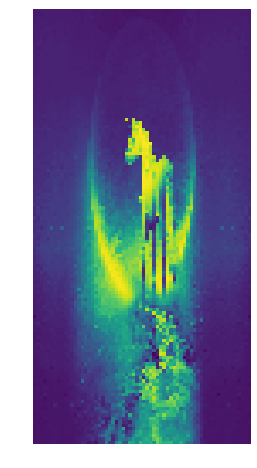

In [354]:
plot_img(img)

In [355]:
hog = HoGExtractor(img)

In [356]:
hog = hog.extract_feature()

In [360]:
for x in range(hog.shape[0]):
    print(hog[x])

0.003911519966629559
0.0001409985444167746
0.10170371126024332
0.30706406870486774
0.011128376624424133
0.0929045483687993
0.0
0.0
0.0
0.0005283501503992364
5.0871950669349545e-05
0.10239680101816138
0.3054034817000767
0.03771450379359017
0.33713433183708513
0.0
0.0
0.0
0.004375620034837044
0.0002561205772778756
0.05131050268324978
0.1536578362144463
0.03136543610435183
0.27922741594173517
0.0
0.0
0.0
0.0007895237461938668
5.687500179608434e-05
0.18749306627884224
0.560690264617215
0.05122028329856067
0.4586863473508648
0.0
0.0
0.0
0.0034502107327487974
0.00011518012474600883
0.028336642664448228
0.08482504388181897
0.038876249701718435
0.33754131048285596
0.0
0.0
0.0
0.0005761550088739093
9.875457660061415e-06
0.13985417701112826
0.42068396422861476
0.04127792172873881
0.36982245054484164
0.0
0.0
0.0
0.005838197699856237
0.00031512219875045537
0.13046066425938901
0.3923248537982305
0.011934018808617424
0.10302811833935664
0.0
0.0
0.0
0.006011444990907317
0.00014187490769937698
0.18552

IndexError: tuple index out of range

(27, 30, 3)

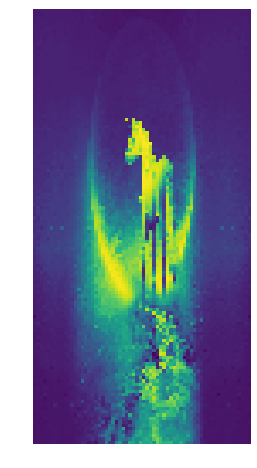

In [155]:
img.shape

(128, 64)

AttributeError: 'NoneType' object has no attribute 'shape'

In [87]:
len(s[0])

36

In [155]:
a[1] = a[1] + 5

In [156]:
[x for x in range(0,64,8)]

[0, 8, 16, 24, 32, 40, 48, 56]

In [161]:
a/np.sqrt(np.sum(a**2))

array([0., 1., 0., 0., 0., 0., 0., 0., 0.])